<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/object-detection/object_detection_transfer_learning_dataset_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

This is a toy program which illustrates the customization of a trained object detection model, to fit another detection problem.

As a `Toy Program`, it replaces real imaged data by a randomly generated images data, along with manipulated number of class categories, and number of objects per an example image.



##Clone Model Garden 

This repo holds, between other things, a collection object detection models which we will re-use.

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3129, done.
remote: Counting objects: 100% (3129/3129), done.
remote: Compressing objects: 100% (2454/2454), done.
remote: Total 3129 (delta 833), reused 1496 (delta 631), pack-reused 0
Receiving objects: 100% (3129/3129), 33.34 MiB | 28.26 MiB/s, done.
Resolving deltas: 100% (833/833), done.


##Compile Object Detection Protobuf - Essential to do

In [2]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1684828 sha256=322f0ef30216abdd01b544ef873fc1fbe159f6c07947c0e78d3b02a140dca754
  Stored in directory: /tmp/pip-ephem-wheel-cache-g4zpewjk/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=4f5ec698e2e020a4f9ab359f3b733b8cfceb555ba3c4cd30000bb257f67b3fe6
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=da6723ad68c72d3011c95d3979100f0d61141eea08c48ffa08d30e0659cdf225
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=406aabb98156e2eab911e9aed111f31b29a31ac7996c053836

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Imports

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
import tensorflow_datasets as tfds

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

from tqdm import tqdm

%matplotlib inline

## Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [4]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-01-25 08:03:25--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   191MB/s    in 1.2s    

2022-01-25 08:03:26 (191 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



##Fine Tuning Preparetions - Modify Model's Configuration

Restore weights for all but classification head layer, i.e.:
- Restore `_base_tower_layers_for_heads`, - the model tower layers are the base layers)

- Restore `_box_prediction_head` - the box prediction head

- Omit the restore of `_prediction_heads` - the classification head
 
 The classification head is not restored, as its weights should be specific to the current model.

In [5]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 120
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
temp_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor.,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
temp_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=temp_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=temp_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


##Data Parameters Setup

In [6]:
#@title Data Parameters Setup { run: "auto" }
# batch_size =  16#@param {type:"integer"}

num_batches = 100 #@param {type:"integer"}

image_height = 640 #@param {type:"integer"}

image_width = 640 #@param {type:"integer"}


## Train Function



##Create Dataset old

##Download Dataset


- The dataset consists of 2 splits: Train and Test
- The Test split is farther sliced here into validation and test splits
- dataset is downloaded with attribute `as_supervised`=False (this is the default).
   - reason: the bounding boxes data, which we will use, is avbailable only in this mode.
   - implications: the dataset in this mode is arrange is a dict object. 
   - required action: as part of input pipeline preparations, we will reformat_dataset from the dict formatted to a tuple format.



In [7]:
train_ds, info = tfds.load(
    name='StanfordDogs',
    split='train', 
    with_info=True,
)

(val_ds, test_ds) = tfds.load(
    name='StanfordDogs',
    split=['test[:80%]', 
    'test[80%:]'],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDHR6E7/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDHR6E7/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


####Extract Number of Classes and Class names From Dataset's Attributes

In [8]:
num_classes = info.features['label'].num_classes
print('num_classes: ', num_classes)
class_names = info.features['label'].names
print('class_names: ',class_names)

num_classes:  120
class_names:  ['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_

## 3. Create Input Pipeline 
---

####Remove Dataset Entries with Multi Objects
- Some of the images consist of more than a single dog
- To simplify the model, we will use only images with a single dog with a single bounding box

In [9]:
def remove_multi_objects_images(ds):
    ds = ds.filter(lambda data: tf.shape(data['objects']['bbox'])[0] == 1)
    return  ds

train_ds = remove_multi_objects_images(train_ds)  
test_ds = remove_multi_objects_images(test_ds)  
val_ds = remove_multi_objects_images(val_ds)  


#### Reformat Datasets From Dict to Tupple
- Dataset was downloaded with as_supervised=False - see notes above

In [10]:
def dict_to_tupple(data):
    image = data["image"]
    bbox = data['objects']['bbox']
    class_label = data["label"]
    # class_label = tf.expand_dims(class_label, axis=0)

    # class_label = tf.reshape(bbox.shape[0], bbox.shape[0], bbox.shape[1], bbox.shape[2])
    # return image, ( tf.expand_dims(tf.one_hot(class_label, num_classes), axis=0)), bbox)
    return image, ( tf.one_hot(class_label, num_classes), bbox)

def reformat_dataset(dataset):      
    reformatted_dataset = dataset.map(dict_to_tupple, 
                                                 num_parallel_calls=16)
    return reformatted_dataset
    return reformatted_dataset

train_ds = reformat_dataset(train_ds)
val_ds = reformat_dataset(val_ds)
test_ds = reformat_dataset(test_ds)


####Visualize Dataset Images - Before Resizing and Batching

####**Some Values Setup**


- **batch size**: A batch size of 32 is a good starting point. There's a trade-off here, were a too small batch size might lead to a too slow processing due to lacking vectorization. A too large batch might leads to low accuracy and thus longer training time.


In [11]:
#@title Set Batch Size { run: "auto" }

batch_size = 8#@param {type:"integer"}



- **image_height**, **image_width**: The are tradeoffs in setting the input dimenssions: keeping details vs process load. Anyway, since source data image is mostly none size uniform, resizing is essential. Since the NN deployed here has 5 pooling modules, which reduce size overall by 32, the size was set to a multiply of 32.

In [12]:
#@title Set Input Image Resized Dimenssions { run: "auto" }

image_height = 224#@param {type:"integer"}
image_width =  224#@param {type:"integer"}

In [13]:
def resize_image(image, label):
    image = tf.image.resize(image, [image_height, image_width])
    return  image, label

train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)
val_ds = val_ds.map(resize_image)


## 4. Configure Dataset for Performance
---

**Configure the Dataset for Performance**

Some essential data transformations were already performed by `image_dataset_from_directory`. 

That includes **`batching`**, **`image format decoding`**, **`splitting`** and `resizing`.

Those transformation were essential for the execution of the network.


Next transormations are needed to improve performance:


- **cache** -  keeps the images in memory after they're loaded off disk during 
the first epoch.

- **shuffle** - fills a buffer with buffer_size elements, then randomly samples elements from this buffer. The sampled elements are replaced by new dataset elements as depicted in the diagram below. 

- **prefetch** -  overlaps data preprocessing and model execution while training. (The tf.data.AUTOTUNE parameter defines a dynamic tuning of the number of prefetched data elements. The number depends on the number of batches consumed in a single step, i.e. on parallelism extent). In case both **perfecth** and **shuffle** are set, the shuffle buffer should be greater than or equal to the full size of the dataset.

- **normalization** - standardizes the inputs to the range [0,1], which improves performance.


- **augmentation** - expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts, and shear.




In [14]:
def configure_for_performance(ds):
  # ds = ds.cache()
  ds = ds.shuffle(buffer_size=500)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

**Data Augmentation** - Expand training dataset size

In [15]:
# data_augmentation = tf.keras.Sequential(
#   [
#     tf.keras.layers.RandomFlip("horizontal",
#                       input_shape=(image_height,
#                                   image_width,
#                                   3)),
#     tf.keras.layers.RandomRotation(0.1, fill_mode="nearest",),
#     tf.keras.layers.RandomZoom(0.1),
#   ]
# )

#####Visualize Data Examples

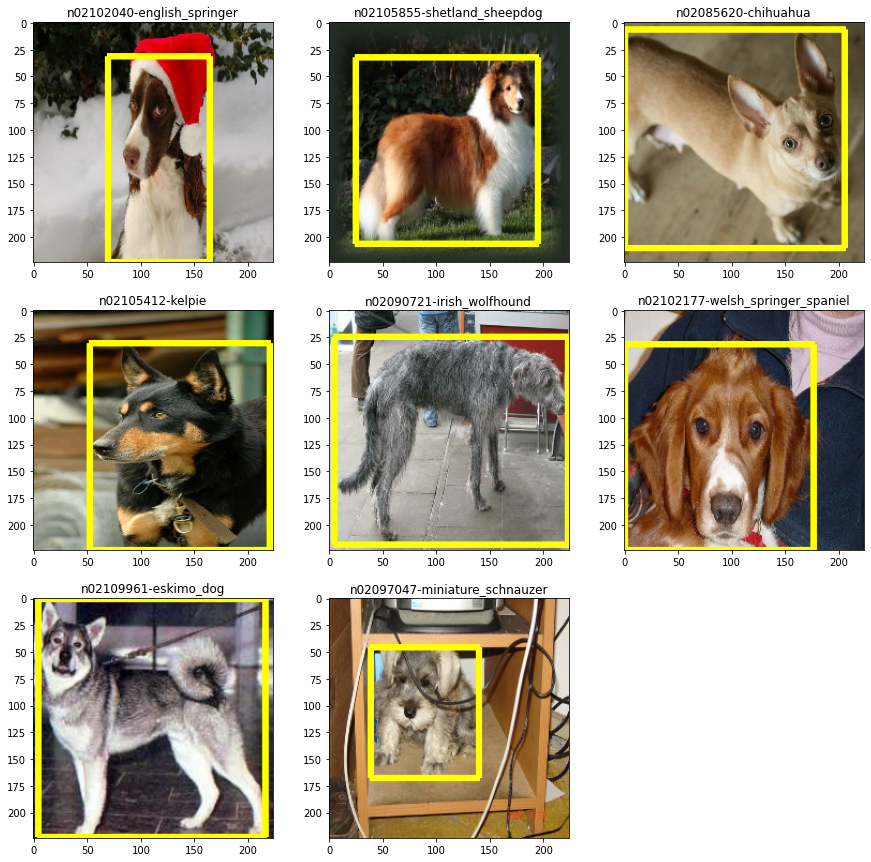

In [56]:
import PIL
from PIL import Image, ImageDraw

def draw_bounding_box(image, ymin, xmin, ymax, xmax, color, thickness=3):
  draw = ImageDraw.Draw(image)
  draw.line([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin),
             (xmin, ymin)],
            width=thickness,
            fill=color)
  return image

get_label_name = info.features['label'].int2str
plt.figure(figsize=(15, 15))

images, labels = next(iter(train_ds))
class_categories, boxes = labels
for idx, (image, class_cat, bbox) in enumerate(zip(images, class_categories, boxes)):
  ax = plt.subplot(3, 3, idx+1)
  image_pil = Image.fromarray(np.uint8(image.numpy()))
  im_width, im_height = image_pil.size
  ymin, xmin, ymax, xmax = ((bbox) * [im_height, im_width, im_height, im_width])[0]
  draw_bounding_box(image_pil, ymin, xmin, ymax, xmax, color=(255,255,0), thickness=6)
  ax.imshow(image_pil)
  ax.set_title(class_names[np.argmax(class_cat)])

Set Augmentation to training dataset

In [353]:
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

## Train Function



In [354]:
tf.keras.backend.set_learning_phase(True)


learning_rate = 0.01

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def batch_train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    # shapes = tf.constant(batch_size * [[image_height, image_width, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)


    with tf.GradientTape() as tape:
      # preprocessed_images = tf.concat(
      #     [detection_model.preprocess(image_tensor)[0]
      #      for image_tensor in image_tensors], axis=0)

      preprocessed_image, shapes = detection_model.preprocess(image_tensors)
  # prediction_dict = detection_model.predict(preprocessed_image, shapes)
  # return detection_model.postprocess(prediction_dict, shapes)


      preprocessed_images = image_tensors
      prediction_dict = model.predict(preprocessed_images, shapes)
      
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return batch_train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
batch_train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)


/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


##Do Fine Tuning

In [356]:
def train_data_for_one_epoch():
  losses = []
  total_loss = None
  # pbar = tqdm(total=len(list(enumerate(train_ds))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  epochs = 1
  for epoch in range(epochs):
    print(f'epoch={epoch}')
    for step, (image_batch_train, label_batch_train) in enumerate(train_ds):
        classes, boxes = label_batch_train
        classes=tf.expand_dims(classes, axis=1)
        shapes = tf.constant(batch_size * [[image_height, image_width, 3]], dtype=tf.int32)
        boxes_list = [box for box in boxes]
        classes_list = [aclass for aclass in classes]
        total_loss = batch_train_step_fn(image_batch_train, boxes_list, classes_list)
        # losses.append(total_loss.numpy())
        if step % 10 == 0:
          print('batch ' + str(step) + ' of ' + str(num_batches)
          + ', loss=' +  str(total_loss.numpy()), flush=True)
        # pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        # pbar.update()
    losses.append(total_loss.numpy())
    if step % 1 == 0:
          print('Epoch ' + str(epoch) + ' of ' + str(epochs)
          + ', loss=' +  str(total_loss.numpy()), flush=True)
  return losses

In [357]:
train_data_for_one_epoch()

epoch=0
batch 0 of 100, loss=1.2495393
Epoch 0 of 1, loss=1.2712225


[1.2712225]

In [358]:
image_batch_train, label_batch_train = next(iter(train_ds))
# preprocessed_image, shapes = detection_model.preprocess(image_batch_train)
# prediction_dict = detection_model.predict(preprocessed_image, shapes)
# # detection_model.postprocess(prediction_dict, shapes)



In [359]:
img=tf.expand_dims(image_batch_train[0], axis=0)
preprocessed_image, shapes = detection_model.preprocess(img)
prediction_dict = detection_model.predict(preprocessed_image, shapes)
# # detection_model.postprocess(prediction_dict, shapes)

In [360]:
prediction_dict.keys()
prediction_dict['class_predictions_with_background']
# prediction_dict['box_encodings']

<tf.Tensor: shape=(1, 51150, 121), dtype=float32, numpy=
array([[[-4.678706 , -4.6233287, -4.5417957, ..., -4.9851956,
         -4.2605896, -4.9056516],
        [-4.506015 , -4.5644317, -4.5275507, ..., -5.0316706,
         -4.03357  , -4.1891875],
        [-4.075422 , -4.7069225, -4.7284484, ..., -4.417211 ,
         -4.208331 , -4.4602323],
        ...,
        [-4.762768 , -4.723533 , -4.374782 , ..., -4.6641192,
         -4.6200128, -5.0675273],
        [-4.1517115, -4.617252 , -4.3669715, ..., -4.132444 ,
         -4.703454 , -4.395102 ],
        [-4.877903 , -4.2632217, -5.052617 , ..., -4.7832403,
         -4.9981074, -4.554392 ]]], dtype=float32)>

In [332]:
shapes

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[640, 640,   3]], dtype=int32)>

In [ ]:
prediction_dict.keys()
np.argmax(prediction_dict['class_predictions_with_background'][0])
np.argmax(prediction_dict['class_predictions_with_background'][0][0])
prediction_dict['class_predictions_with_background'][0][8]

# Load test images and run inference with new model!

In [272]:
# test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
# test_images_np = []
# for i in range(1, 50):
#   image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
#   test_images_np.append(np.expand_dims(
#       load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

NameError: ignored

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))